# Libs

In [1]:
from ibm_botocore.client import Config
import ibm_boto3

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200209102530-0000
KERNEL_ID = 9b1576ab-377e-48f7-a660-041274ac362b


In [2]:
SEED = 42

# Numpy
import numpy as np
np.random.seed(SEED)

# Pandas
import pandas as pd

# Sklearn

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import cross_validate, learning_curve, train_test_split

# Metrics and tuning
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense

# Stats
from scipy import stats

# Vizualization
import seaborn as sns
sns.set(style="whitegrid")

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Using TensorFlow backend.


# Data

In [3]:
credentials = {
    'IAM_SERVICE_ID': '',
    'IBM_API_KEY_ID': '',
    'ENDPOINT': '',
    'IBM_AUTH_ENDPOINT': '',
    'BUCKET': '',
    'FILE': ''
}

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

cos.download_file(Bucket=credentials['BUCKET'], Key='cleaned_data_2', Filename='cleaned_data_2.csv')

df = pd.read_csv('cleaned_data_2.csv')

In [4]:
df['Neoplasm Histologic Grade'] = df['Neoplasm Histologic Grade'].astype('category')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1674 entries, 0 to 1673
Data columns (total 16 columns):
Age at Diagnosis                  1674 non-null float64
Cellularity                       1674 non-null object
Pam50 + Claudin-low subtype       1674 non-null object
ER status measured by IHC         1674 non-null object
ER Status                         1674 non-null object
Neoplasm Histologic Grade         1674 non-null category
HER2 status measured by SNP6      1674 non-null object
HER2 Status                       1674 non-null object
Tumor Other Histologic Subtype    1674 non-null object
Inferred Menopausal State         1674 non-null object
Integrative Cluster               1674 non-null object
Lymph nodes examined positive     1674 non-null float64
Mutation Count                    1674 non-null float64
PR Status                         1674 non-null object
Tumor Size                        1674 non-null float64
Patient's Vital Status            1674 non-null int64
dtypes: 

# Separating target

In [6]:
y = df["Patient's Vital Status"]

In [7]:
df = df.drop(columns=["Patient's Vital Status"])

# Features transformation

Text(0.5, 0, 'Lymph nodes examined positive')

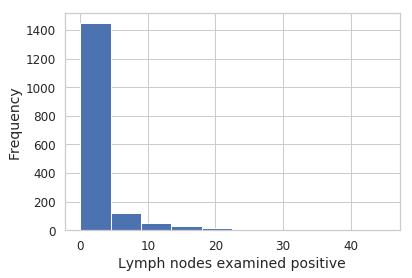

In [8]:
df['Lymph nodes examined positive'].plot.hist()
plt.xlabel('Lymph nodes examined positive', fontsize=14)

The data is skewed, had a lot of zero values. We need to decide what to do with it. One of the typical transformation strategies, in this case, is "log(x+1)" transformation.

More info: http://onbiostatistics.blogspot.com/2012/05/logx1-data-transformation.html

Text(0.5, 0, 'Log Lymph nodes examined positive')

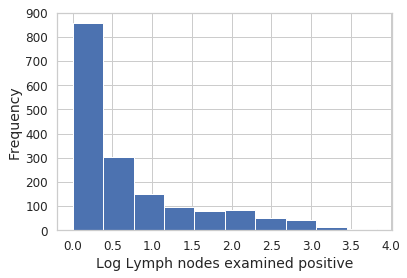

In [9]:
f = df['Lymph nodes examined positive']
f_log = f.map(lambda x: np.log(x+1))

f_log.plot.hist()
plt.xlabel('Log Lymph nodes examined positive', fontsize=14)

In [10]:
df['Lymph nodes examined positive'] = df['Lymph nodes examined positive'].apply(lambda x: np.log(x+1))

Now, the feature looks much better. Let's take a look at other features with skewed distribution:

Text(0.5, 0, 'Mutation Count')

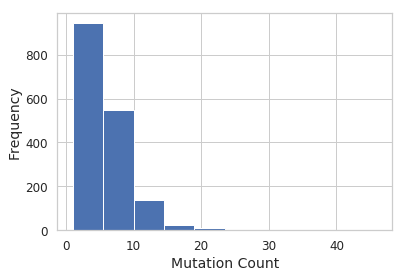

In [11]:
df['Mutation Count'].plot.hist()
plt.xlabel('Mutation Count', fontsize=14)

Text(0.5, 0, 'Log Lymph nodes examined positive')

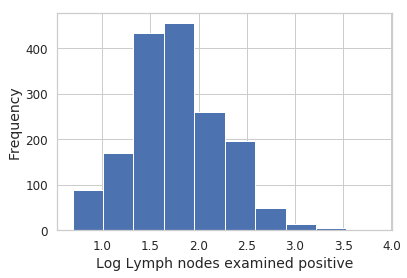

In [12]:
f = df['Mutation Count']
f_log = f.map(lambda x: np.log(x+1))

f_log.plot.hist()
plt.xlabel('Log Lymph nodes examined positive', fontsize=14)

In [13]:
df['Mutation Count'] = df['Mutation Count'].apply(lambda x: np.log(x+1))

Text(0.5, 0, 'Tumor Size')

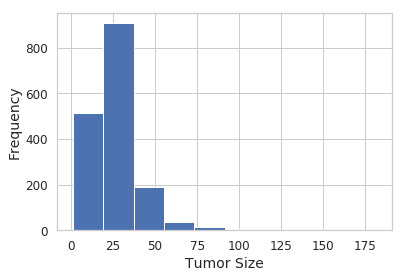

In [14]:
df['Tumor Size'].plot.hist()
plt.xlabel('Tumor Size', fontsize=14)

Text(0.5, 0, 'Tumor Size')

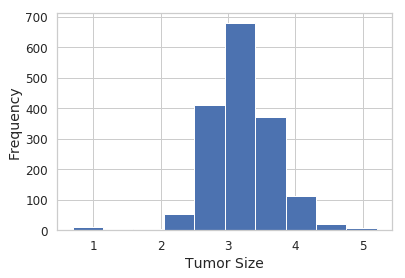

In [15]:
f = df['Tumor Size']
f_log = f.map(lambda x: np.log(x+1))

f_log.plot.hist()
plt.xlabel('Tumor Size', fontsize=14)

In [16]:
df['Tumor Size'] = df['Tumor Size'].apply(lambda x: np.log(x+1))

# One-Hot encoding

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1674 entries, 0 to 1673
Data columns (total 15 columns):
Age at Diagnosis                  1674 non-null float64
Cellularity                       1674 non-null object
Pam50 + Claudin-low subtype       1674 non-null object
ER status measured by IHC         1674 non-null object
ER Status                         1674 non-null object
Neoplasm Histologic Grade         1674 non-null category
HER2 status measured by SNP6      1674 non-null object
HER2 Status                       1674 non-null object
Tumor Other Histologic Subtype    1674 non-null object
Inferred Menopausal State         1674 non-null object
Integrative Cluster               1674 non-null object
Lymph nodes examined positive     1674 non-null float64
Mutation Count                    1674 non-null float64
PR Status                         1674 non-null object
Tumor Size                        1674 non-null float64
dtypes: category(1), float64(4), object(10)
memory usage: 184.

In [18]:
numeric_cols = ['Age at Diagnosis', 'Lymph nodes examined positive', 'Tumor Size', 'Mutation Count']
categorical_cols = list(set(df.columns.values.tolist()) - set(numeric_cols))

In [19]:
data_cat = df[categorical_cols]
data_num = df[numeric_cols]

In [20]:
enc = OneHotEncoder(sparse=False)
data_cat_oh = enc.fit_transform(data_cat)

In [21]:
data_cat_oh.shape

(1674, 45)

# Splitting dataset

Now we need to split our dataset into the train and test sets. 

Let's ensure that our classes are balanced:

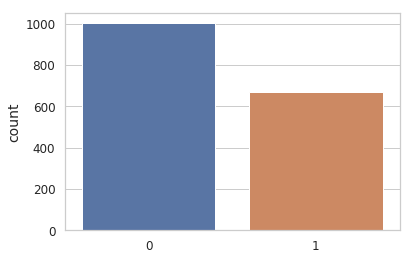

In [22]:
sns.countplot(y.values)

Ok, so they are not. We can either balance the manually - with over/under sampling. We can also use stratification to be sure that number of class examples are equal in our train and test sets.

In [23]:
(X_train_num, X_test_num, y_train, y_test) = train_test_split(data_num, y, 
                                                              test_size=0.3, 
                                                              random_state=42,
                                                              stratify=y)

(X_train_cat_oh, X_test_cat_oh) = train_test_split(data_cat_oh, 
                                                   test_size=0.3, 
                                                   random_state=42,
                                                   stratify=y)

# Numerical features scaling

In [24]:
scaler = StandardScaler()

X_train_num_scaled = scaler.fit_transform(X_train_num, y_train)
X_test_num_scaled = scaler.transform(X_test_num)

 # Creating final train and test datasets

In [25]:
train_data = np.hstack((X_train_num_scaled, X_train_cat_oh))
test_data = np.hstack((X_test_num_scaled, X_test_cat_oh))

In [26]:
from numpy import savetxt

In [27]:
savetxt('train.csv', train_data, delimiter=',')
savetxt('test.csv', test_data, delimiter=',')
savetxt('y_train.csv', y_train, delimiter=',')
savetxt('y_test.csv', y_test, delimiter=',')

In [28]:
cos.upload_file(Filename='train.csv',Bucket=credentials['BUCKET'], Key='train')
cos.upload_file(Filename='test.csv',Bucket=credentials['BUCKET'], Key='test')
cos.upload_file(Filename='y_train.csv',Bucket=credentials['BUCKET'], Key='y_train')
cos.upload_file(Filename='y_test.csv',Bucket=credentials['BUCKET'], Key='y_test')

# Feature Imputation

We need to do all the steps above for a new dataset with imputed features

In [29]:
cos.download_file(Bucket=credentials['BUCKET'], Key='imputed_data', Filename='imputed_data.csv')

df_imputed = pd.read_csv('imputed_data.csv')

In [30]:
df_imputed['Neoplasm Histologic Grade'] = df_imputed['Neoplasm Histologic Grade'].astype('category')

In [31]:
y_imputed = df_imputed["Patient's Vital Status"]
df_imputed = df_imputed.drop(columns=["Patient's Vital Status"])

In [32]:
df_imputed['Tumor Size'] = df_imputed['Tumor Size'].apply(lambda x: np.log(x+1))
df_imputed['Lymph nodes examined positive'] = df_imputed['Lymph nodes examined positive'].apply(lambda x: np.log(x+1))

In [33]:
numeric_cols = ['Age at Diagnosis', 'Lymph nodes examined positive', 'Tumor Size']
categorical_cols = list(set(df_imputed.columns.values.tolist()) - set(numeric_cols))

In [34]:
data_cat = df_imputed[categorical_cols]
data_num = df_imputed[numeric_cols]

In [35]:
enc = OneHotEncoder(sparse=False)
data_cat_oh = enc.fit_transform(data_cat)

In [37]:
(X_train_num, X_test_num, y_train, y_test) = train_test_split(data_num, y_imputed, 
                                                              test_size=0.3, 
                                                              random_state=42,
                                                              stratify=y_imputed)

(X_train_cat_oh, X_test_cat_oh) = train_test_split(data_cat_oh, 
                                                   test_size=0.3, 
                                                   random_state=42,
                                                   stratify=y_imputed)

In [38]:
scaler = StandardScaler()

X_train_num_scaled = scaler.fit_transform(X_train_num, y_train)
X_test_num_scaled = scaler.transform(X_test_num)

In [39]:
train_data = np.hstack((X_train_num_scaled, X_train_cat_oh))
test_data = np.hstack((X_test_num_scaled, X_test_cat_oh))

In [42]:
train_data[:1]

array([[1.74460015, 2.47295118, 3.81002246, 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.        ]])

In [ ]:
savetxt('train_imputed.csv', train_data, delimiter=',')
savetxt('test_imputed.csv', test_data, delimiter=',')
savetxt('y_train_imputed.csv', y_train, delimiter=',')
savetxt('y_test_imputed.csv', y_test, delimiter=',')

In [ ]:
cos.upload_file(Filename='train_imputed.csv',Bucket=credentials['BUCKET'], Key='train_imputed')
cos.upload_file(Filename='test_imputed.csv',Bucket=credentials['BUCKET'], Key='test_imputed')
cos.upload_file(Filename='y_train_imputed.csv',Bucket=credentials['BUCKET'], Key='y_train_imputed')
cos.upload_file(Filename='y_test_imputed.csv',Bucket=credentials['BUCKET'], Key='y_test_imputed')